In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import pandas as pd
from pandas_datareader import data 
import matplotlib.pyplot as plt

sns.set(style='darkgrid', context='talk', palette='Dark2')

Having imported the appropriate tools, getting market data from a free online source, such as Yahoo Finance, is super easy. Since pandas has a simple remote data access for the Yahoo Finance API data, this is as simple as:

In [81]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
# tickers = ['AAPL', 'MSFT', 'GOOG', 'META']
tickers = ['AAPL']

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2000-01-01'
end_date = '2022-10-31'

# User pandas_reader.data.DataReader to load the desired data.
df = data.DataReader(tickers, 'yahoo', start_date, end_date)

In [82]:
df

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2000-01-03,0.853355,0.999442,1.004464,0.907924,0.936384,535796800.0
2000-01-04,0.781409,0.915179,0.987723,0.903460,0.966518,512377600.0
2000-01-05,0.792843,0.928571,0.987165,0.919643,0.926339,778321600.0
2000-01-06,0.724232,0.848214,0.955357,0.848214,0.947545,767972800.0
2000-01-07,0.758538,0.888393,0.901786,0.852679,0.861607,460734400.0
...,...,...,...,...,...,...
2022-10-25,152.339996,152.339996,152.490005,149.360001,150.089996,74732300.0
2022-10-26,149.350006,149.350006,151.990005,148.039993,150.960007,88194300.0


In [83]:
tesla = data.DataReader('TSLA', 'yahoo', start_date, end_date)
tesla

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,1.666667,1.169333,1.266667,1.592667,281494500.0,1.592667
2010-06-30,2.028000,1.553333,1.719333,1.588667,257806500.0,1.588667
2010-07-01,1.728000,1.351333,1.666667,1.464000,123282000.0,1.464000
2010-07-02,1.540000,1.247333,1.533333,1.280000,77097000.0,1.280000
2010-07-06,1.333333,1.055333,1.333333,1.074000,103003500.0,1.074000
...,...,...,...,...,...,...
2022-10-25,224.350006,210.000000,210.100006,222.419998,96507900.0,222.419998
2022-10-26,230.600006,218.199997,219.399994,224.639999,85012500.0,224.639999
2022-10-27,233.809998,222.850006,229.770004,225.089996,61638800.0,225.089996


#### Preparing the Data

Let us assume we are interested in working with the Close prices which have been already been adjusted by Yahoo finance to account for stock splits. We want to make sure that all weekdays are included in our dataset, which is very often desirable for quantitative trading strategies.

Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices:

In [84]:
# # Getting just the adjusted closing prices. This will return a Pandas DataFrame
# # The index in this DataFrame is the major index of the data frame.
# close = df['Close']
# volume = df['Volume']
# open = df['Open']

# # Getting all weekdays between 01/01/2000 and 12/31/2016  https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
# all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency

# # How do we align the existing prices in adj_close with our new set of dates?
# # All we need to do is reindex close using all_weekdays as the new index     https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html
# close = close.reindex(all_weekdays)
# volume = volume.reindex(all_weekdays)

# # Reindexing will insert missing values (NaN) for the dates that were not present
# # in the original set. To cope with this, we can fill the missing by replacing them
# # with the latest available price for each instrument.  https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html
# close = close.fillna(method='ffill')
# volume = volume.fillna(method='ffill')


In [85]:
close.to_csv("CSV/close.csv", index=True) # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
volume.to_csv("CSV/volume.csv", index=True)

In [86]:
close.describe()

Symbols,AAPL
count,5956.000000
mean,29.094847
std,42.206520
min,0.234286
25%,1.813661
50%,12.520000
75%,33.775626
max,182.009995


In [87]:
volume.describe()

Symbols,AAPL
count,5.956000e+03
mean,4.140489e+08
std,3.852923e+08
min,3.934000e+07
25%,1.433122e+08
50%,2.980684e+08
75%,5.504835e+08
max,7.421641e+09


In [88]:
open.describe()

Symbols,AAPL
count,5745.000000
mean,29.121354
std,42.210282
min,0.231964
25%,1.823571
50%,12.522857
75%,33.880001
max,182.630005


In [89]:
def close_print(stock_symbol):
    return data.DataReader(stock_symbol, 'yahoo', start_date, end_date)

In [90]:
def close_print(stock_symbol):
    
    df = data.DataReader(stock_symbol, 'yahoo', start_date, end_date)
    close = df['Close']
    all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency
    close = close.reindex(all_weekdays)
    close = close.fillna(method='ffill')

    for i in stock_symbol:
        # Get the ticker timeseries. This now returns a Pandas Series object indexed by date.
        ticker = close.loc[:, i]

        # Calculate the 20 and 100 days moving averages of the closing prices
        short_rolling_ticker = ticker.rolling(window=20).mean()
        long_rolling_ticker = ticker.rolling(window=100).mean()

        # Plot everything by leveraging the very powerful matplotlib package
        fig, ax = plt.subplots(figsize=(18,11))

        plt.title(i)

        ax.plot(ticker.index, ticker, label=i)
        ax.plot(short_rolling_ticker.index, short_rolling_ticker, label='20 days rolling')
        ax.plot(long_rolling_ticker.index, long_rolling_ticker, label='100 days rolling')

        ax.set_xlabel('Date')
        ax.set_ylabel('Adjusted closing price ($)')
        ax.legend()
    close.to_csv("CSV/close.csv", index=True)


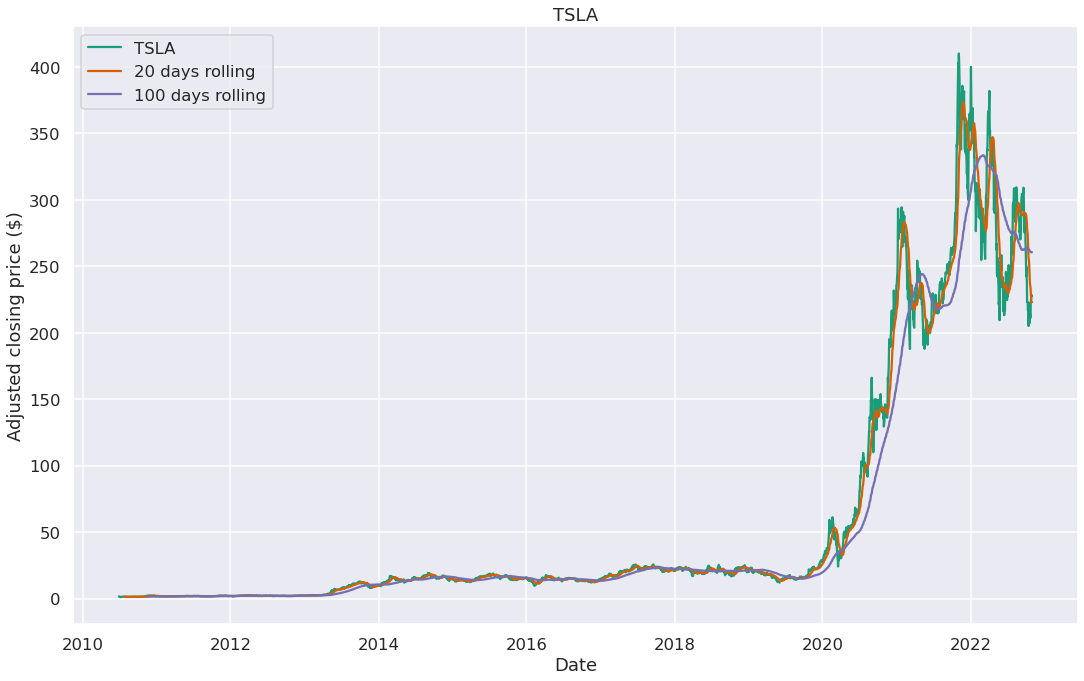

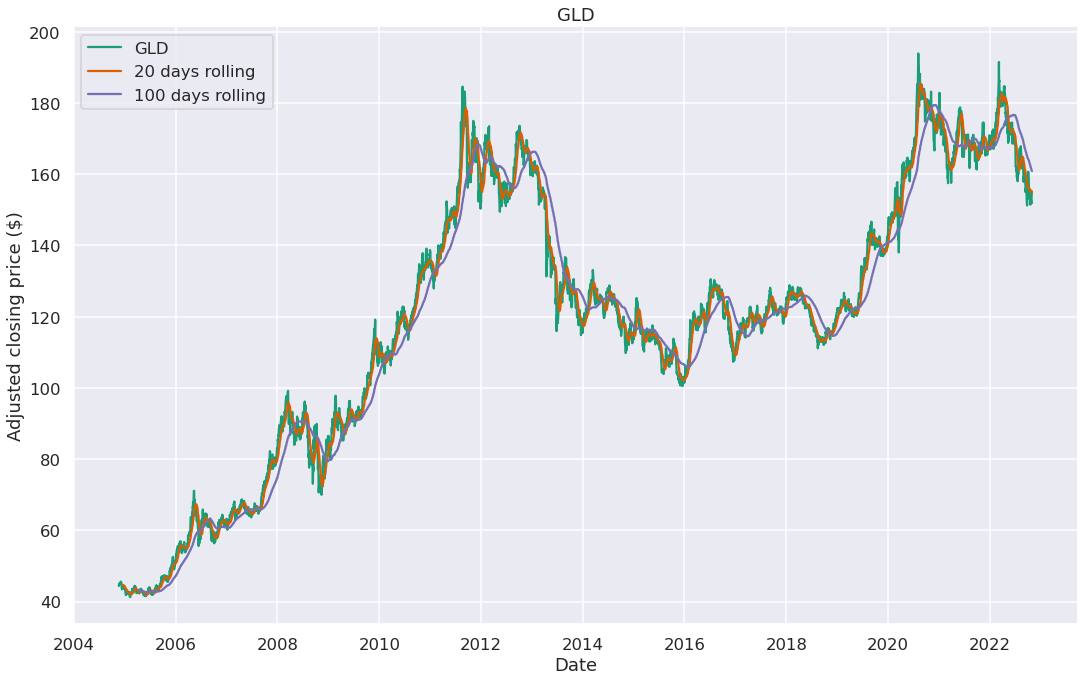

In [91]:
close_print(["TSLA","GLD"])

In [92]:
def volume_print(stock_symbol):
    
    df = data.DataReader(stock_symbol, 'yahoo', start_date, end_date)
    volume = df['Volume']
    all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency
    volume = volume.reindex(all_weekdays)
    volume = volume.fillna(method='ffill')


    for i in stock_symbol:
        # Get the ticker timeseries. This now returns a Pandas Series object indexed by date.
        ticker = volume.loc[:, i]

        # Calculate the 30 and 100 days moving averages of the closing prices
        short_rolling_ticker = ticker.rolling(window=30).mean()
        long_rolling_ticker = ticker.rolling(window=100).mean()

        # short_rolling_ticker = ticker.rolling(window=30, center=True).mean()
        # long_rolling_ticker = ticker.rolling(window=100, center=True).mean()

        # Plot everything by leveraging the very powerful matplotlib package
        fig, ax = plt.subplots(figsize=(18,11))

        plt.title(i)

        ax.plot(ticker.index, ticker, label=i)
        ax.plot(short_rolling_ticker.index, short_rolling_ticker, label='30 days rolling')
        ax.plot(long_rolling_ticker.index, long_rolling_ticker, label='100 days rolling')

        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Volume')
        ax.legend()

    volume.to_csv("CSV/volume.csv", index=True)


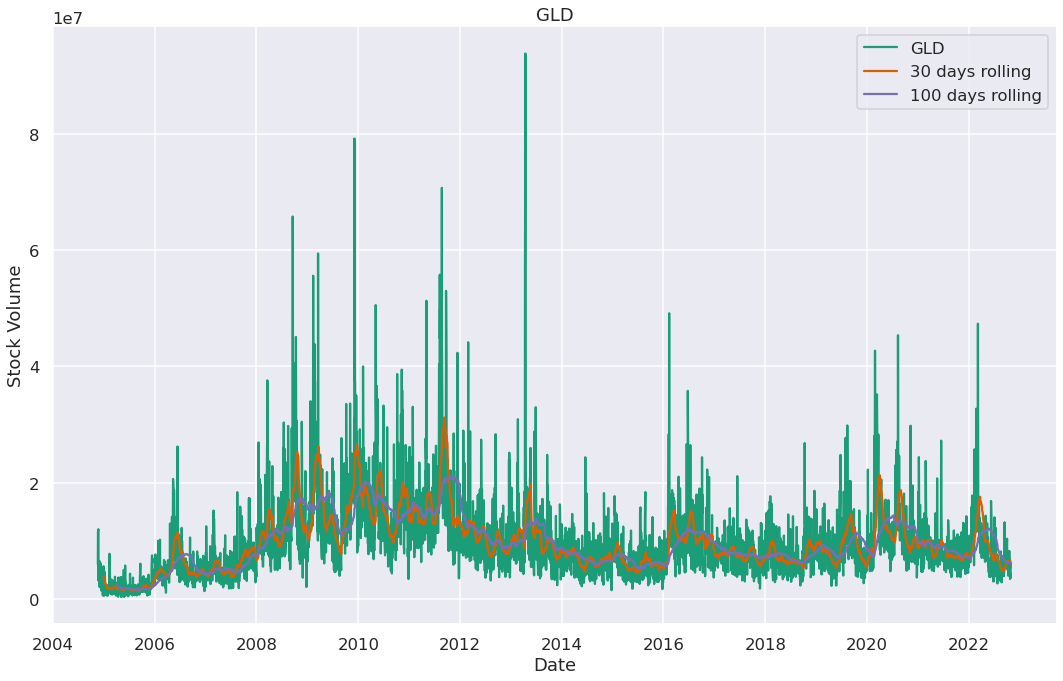

In [93]:
volume_print(['GLD'])

In [94]:
tickers

['AAPL']

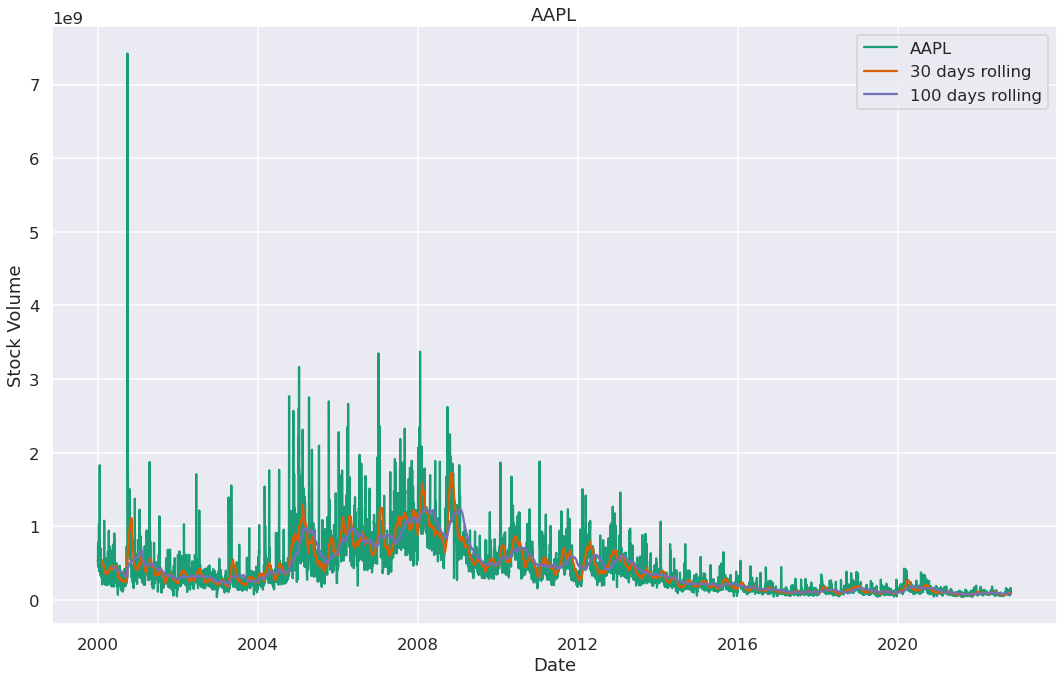

In [95]:
volume_print(['AAPL'])

In [96]:
# Relative returns
returns = df['Close'].pct_change(1)
returns.head()

Symbols,AAPL
Date,
2000-01-03,NaN
2000-01-04,-0.084310
2000-01-05,0.014633
2000-01-06,-0.086538
2000-01-07,0.047369


In [97]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
log_returns = np.log(df['Close']).diff()
log_returns.head()


Symbols,AAPL
Date,
2000-01-03,NaN
2000-01-04,-0.088077
2000-01-05,0.014527
2000-01-06,-0.090514
2000-01-07,0.046281


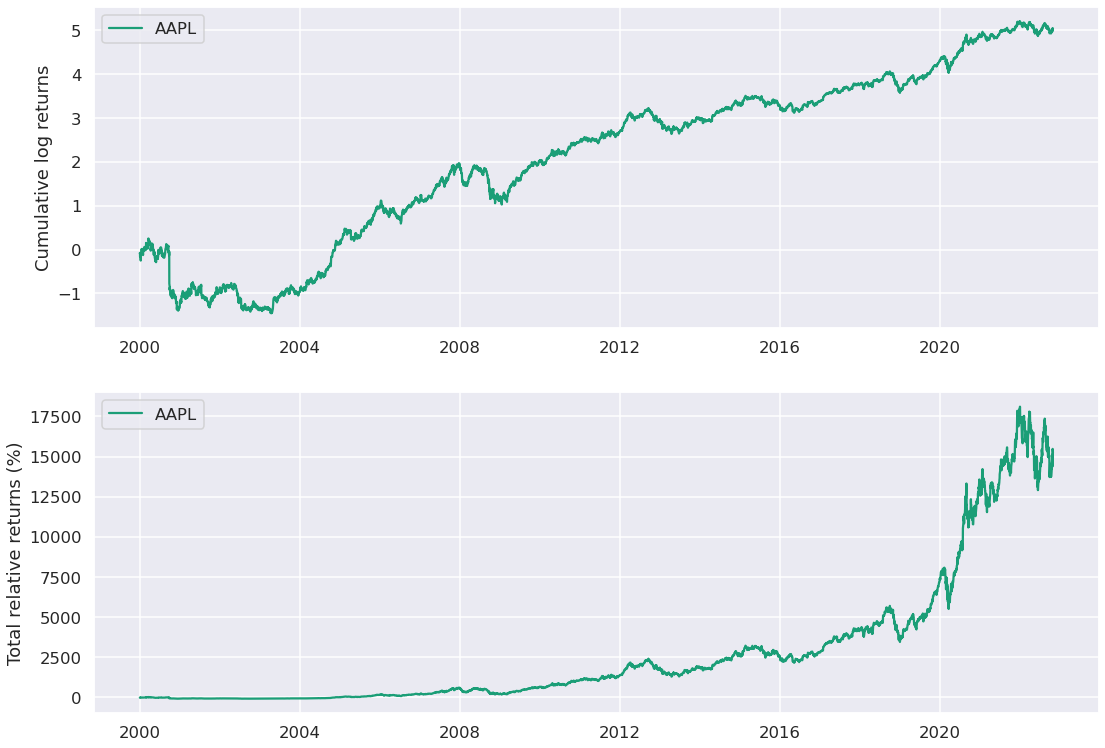

In [98]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,13))

for c in log_returns:
    ax1.plot(log_returns.index, log_returns[c].cumsum(), label=str(c))

ax1.set_ylabel('Cumulative log returns')
ax1.legend(loc='best')

for c in log_returns:
    ax2.plot(log_returns.index, 100*(np.exp(log_returns[c].cumsum()) - 1), label=str(c))

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')

plt.show()


In [99]:
# Last day returns. Make this a column vector
r_t = log_returns.tail(1).transpose()
r_t

Date,2022-10-31
Symbols,
AAPL,-0.01553


In [100]:
# Weights as defined above
weights_vector = pd.DataFrame(1 / 3, index=r_t.index, columns=r_t.columns)
weights_vector

Date,2022-10-31
Symbols,
AAPL,0.333333


In [101]:
# Total log_return for the portfolio is:
portfolio_log_return = weights_vector.transpose().dot(r_t)
portfolio_log_return

Date,2022-10-31
Date,
2022-10-31,-0.005177


In [102]:
weights_matrix = pd.DataFrame(1 / 3, index=df['Close'].index, columns=df['Close'].columns)
weights_matrix.tail()

Symbols,AAPL
Date,
2022-10-25,0.333333
2022-10-26,0.333333
2022-10-27,0.333333
2022-10-28,0.333333
2022-10-31,0.333333


In [103]:
log_returns.head()

Symbols,AAPL
Date,
2000-01-03,NaN
2000-01-04,-0.088077
2000-01-05,0.014527
2000-01-06,-0.090514
2000-01-07,0.046281


In [104]:
# Initially the two matrices are multiplied. Note that we are only interested in the diagonal, 
# which is where the dates in the row-index and the column-index match.
temp_var = weights_matrix.dot(log_returns.transpose())
temp_var.head().iloc[:, 0:5]


Date,2000-01-03,2000-01-04,2000-01-05,2000-01-06,2000-01-07
Date,,,,,
2000-01-03,NaN,-0.029359,0.004842,-0.030171,0.015427
2000-01-04,NaN,-0.029359,0.004842,-0.030171,0.015427
2000-01-05,NaN,-0.029359,0.004842,-0.030171,0.015427
2000-01-06,NaN,-0.029359,0.004842,-0.030171,0.015427
2000-01-07,NaN,-0.029359,0.004842,-0.030171,0.015427


In [105]:
# The numpy np.diag function is used to extract the diagonal and then
# a Series is constructed using the time information from the log_returns index
portfolio_log_returns = pd.Series(np.diag(temp_var), index=log_returns.index)
portfolio_log_returns.tail()

Date
2022-10-25    0.006384
2022-10-26   -0.006607
2022-10-27   -0.010313
2022-10-28    0.024278
2022-10-31   -0.005177
dtype: float64

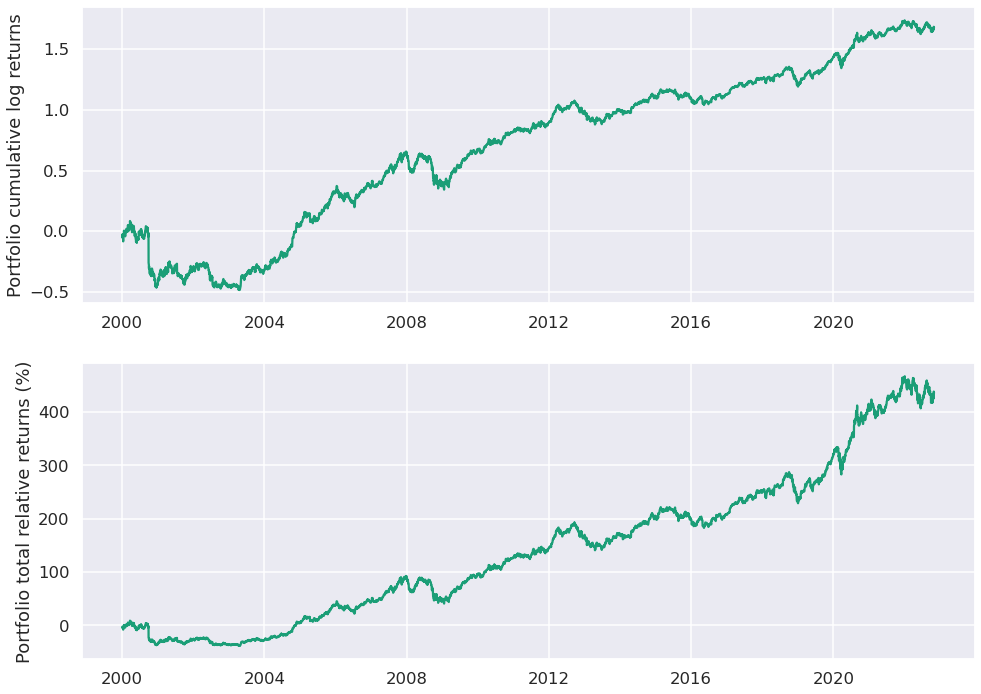

In [106]:
total_relative_returns = (np.exp(portfolio_log_returns.cumsum()) - 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))

ax1.plot(portfolio_log_returns.index, portfolio_log_returns.cumsum())
ax1.set_ylabel('Portfolio cumulative log returns')

ax2.plot(total_relative_returns.index, 100 * total_relative_returns)
ax2.set_ylabel('Portfolio total relative returns (%)')

plt.show()